In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 22
donors_csv = f"./output/donors_state{year}_pred_lastname.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,"A, RAYMOND",raymond a,National Republican Senatorial Cmte,NaN,Z9600,,RETIRED,RETIRED,WASHINGTON,CA,1.649385e+09,115116,1.432803e+04,25.0,a,not
1,U00000003641,"SOROS, GEORGE",george soros,Soros Fund Management,NaN,F2700,M,EXECUTIVE,SOROS FUND MANAGEMENT,NEW YORK,NY,1.800173e+08,204,8.824376e+05,2900.0,soros,not
2,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,8.422153e+07,369,2.282426e+05,2900.0,uihlein,not
3,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,7.437550e+07,317,2.346230e+05,2900.0,griffin,not
4,U00000042451,"YASS, JEFF",jeff yass,Susquehanna International Group,NaN,F2100,M,MANAGING DIRECTOR,SIG,BALA CYNWYD,PA,5.632450e+07,49,1.149480e+06,5800.0,yass,not
5,U0000004705,"BANKMAN-FRIED, SAMUEL",samuel bankman-fried,FTX.US,NaN,F2800,M,CEO,NOT EMPLOYED,NEW PROVIDENC,CA,4.204488e+07,338,1.243931e+05,5000.0,bankman-fried,not
6,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.174640e+07,31,1.346658e+06,2900.0,mellon,not
7,U00000037041,"BLOOMBERG, MICHAEL",michael bloomberg,Bloomberg Lp,NaN,F5500,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,4.133051e+07,39,1.059757e+06,200000.0,bloomberg,not
8,U0000003235,"EYCHANER, FRED",fred eychaner,Newsweb Corp,NaN,C1100,M,PRESIDENT,NEWS WEB CORPORATION,CHICAGO,IL,3.782750e+07,234,1.616560e+05,10000.0,eychaner,not
9,U00000003611,"SCHWARZMAN, STEPHEN",stephen schwarzman,Blackstone Group,NaN,F2600,M,NaN,BLACKSTONE,NEW YORK,NY,3.754490e+07,281,1.336117e+05,2900.0,schwarzman,not


In [4]:
len(donors)

2761018

In [5]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

51.50971586969463


,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,"A, RAYMOND",raymond a,National Republican Senatorial Cmte,NaN,Z9600,,RETIRED,RETIRED,WASHINGTON,CA,1.649385e+09,115116,1.432803e+04,25.0,a,not
1,U00000003641,"SOROS, GEORGE",george soros,Soros Fund Management,NaN,F2700,M,EXECUTIVE,SOROS FUND MANAGEMENT,NEW YORK,NY,1.800173e+08,204,8.824376e+05,2900.0,soros,not
2,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,8.422153e+07,369,2.282426e+05,2900.0,uihlein,not
3,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,7.437550e+07,317,2.346230e+05,2900.0,griffin,not
4,U00000042451,"YASS, JEFF",jeff yass,Susquehanna International Group,NaN,F2100,M,MANAGING DIRECTOR,SIG,BALA CYNWYD,PA,5.632450e+07,49,1.149480e+06,5800.0,yass,not
5,U0000004705,"BANKMAN-FRIED, SAMUEL",samuel bankman-fried,FTX.US,NaN,F2800,M,CEO,NOT EMPLOYED,NEW PROVIDENC,CA,4.204488e+07,338,1.243931e+05,5000.0,bankman-fried,not
6,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.174640e+07,31,1.346658e+06,2900.0,mellon,not
7,U00000037041,"BLOOMBERG, MICHAEL",michael bloomberg,Bloomberg Lp,NaN,F5500,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,4.133051e+07,39,1.059757e+06,200000.0,bloomberg,not
8,U0000003235,"EYCHANER, FRED",fred eychaner,Newsweb Corp,NaN,C1100,M,PRESIDENT,NEWS WEB CORPORATION,CHICAGO,IL,3.782750e+07,234,1.616560e+05,10000.0,eychaner,not
9,U00000003611,"SCHWARZMAN, STEPHEN",stephen schwarzman,Blackstone Group,NaN,F2600,M,NaN,BLACKSTONE,NEW YORK,NY,3.754490e+07,281,1.336117e+05,2900.0,schwarzman,not


In [6]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
37,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,FTX,LOS ALTOS HILLS,CA,8476000.0,148,57270.270270,2900.0,singh,ind
197,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2084900.0,30,69496.666667,5000.0,khosla,ind
385,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H2100,M,FOUNDEE AND CEO,PRIME HEALTHCARE,ONTARIO,CA,1088749.0,78,13958.320513,3205.0,reddy,ind
542,p00042647281,"SRIVASTAVA, GAURAV",gaurav srivastava,Unity Group,NaN,Y4000,M,BUSINESS,UNITY GROUP,LOS ANGELES,CA,854000.0,15,56933.333333,12900.0,srivastava,ind
690,U00000035581,"SATTER, MUNEER A",muneer a satter,Satter Investment Management,NaN,F7000,M,INVESTOR,SATTER INVESTMENT MANAGEMENT,CHICAGO,IL,706900.0,93,7601.075269,2900.0,satter,ind
793,c0140372601,"NARASIMHAN, SHEKAR",shekar narasimhan,Beekman Advisors,NaN,F4700,M,ADVISOR,"BEEKMAN ADVISORS, INC.",DUNN LORING,VA,627265.0,107,5862.289720,2900.0,narasimhan,ind
1011,i30032161751,"CHANDI, NACHHATTAR SINGH",nachhattar singh chandi,Chandi Group Usa,NaN,F4100,M,BUSINESS OWNER,"CHANDI GROUP USA, INC.",INDIO,CA,503100.0,34,14797.058824,9000.0,chandi,ind
1213,n00014894611,"SHAH, NIRAJ",niraj shah,Wayfair Inc,NaN,C6400,M,RETAIL,WAYFAIR,BOSTON,MA,437026.0,64,6828.531250,2900.0,shah,ind
1253,h3001610909,"KHAN, CODY MR",cody mr khan,Holiday Inns,InterContinental Hotels Group,T9100,M,OWNER,HOLIDAY INN RESORT,PANAMA CITY BEACH,FL,424425.0,28,15158.035714,4800.0,khan,ind
1298,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,409400.0,27,15162.962963,3600.0,gandhi,ind


In [7]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

10603275902.0
69612530.0
0.6565190856428589 % of donated amount is from diaspora


In [8]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

2761018
15961
0.5780838806556132 % of donors are from diaspora


In [9]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

4.0
2.0


In [10]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median())

500.0
865.0


In [11]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "ind"]["total_donated"].mean())

3840.3501541822616
4361.414071800013


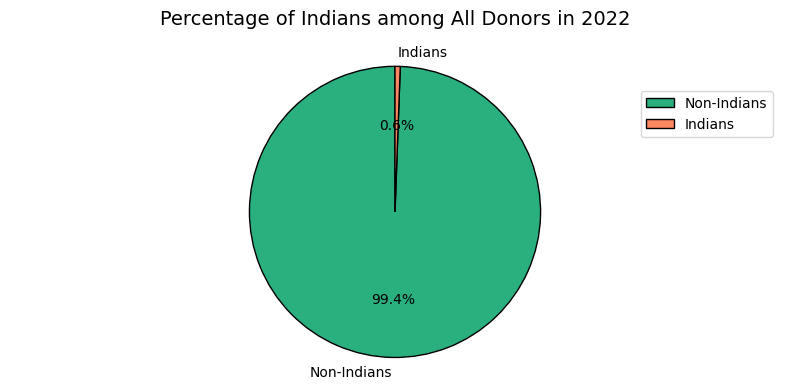

In [12]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Indians among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

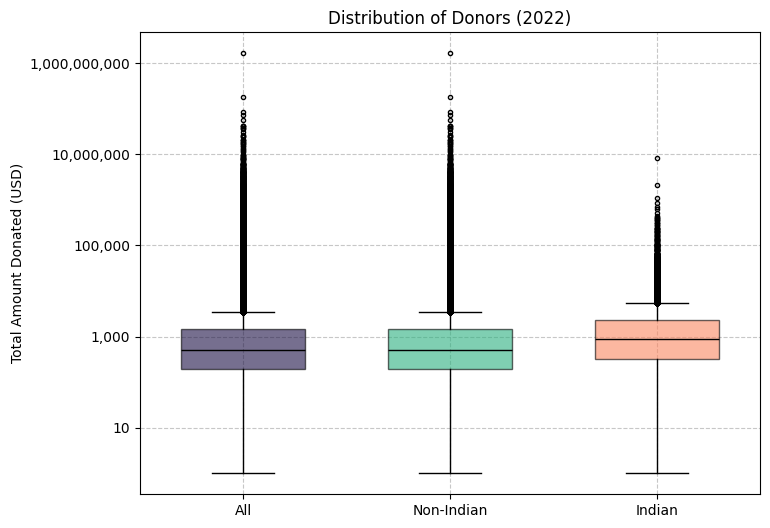

In [13]:
amounts_all = donors['total_donated']
amounts_non_indian = donors[donors['ethnic'] == "not"]['total_donated']
amounts_indian = donors[donors['ethnic'] == "ind"]['total_donated']

plt.figure(figsize=(8, 6))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], 
                   tick_labels=["All", "Non-Indian", "Indian"], 
                   patch_artist=True, 
                   widths=0.6, 
                   medianprops={"color": "black", "linewidth": 1}, 
                   flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title(f"Distribution of Donors (20{year})")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

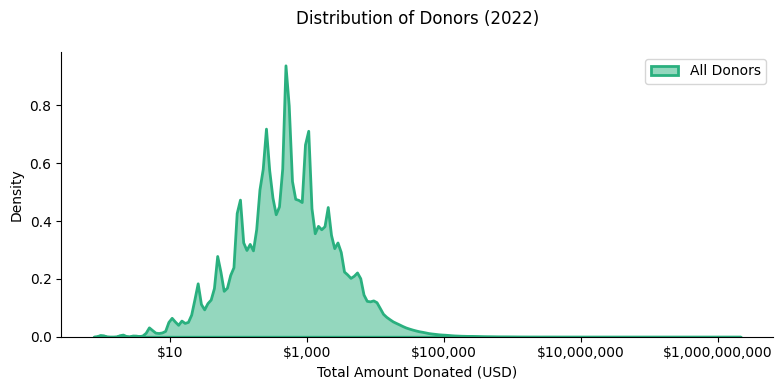

In [14]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
]['total_donated'],
            label='All Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

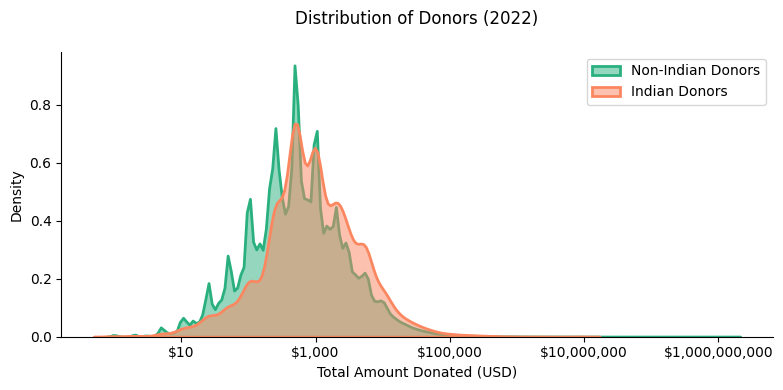

In [15]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "not"]['total_donated'],
            label='Non-Indian Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "ind"]['total_donated'],
            label='Indian Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [16]:
state_stats = (
    donors.groupby("state")
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,CA,8771.084728,500.0,3.140899e+09,358097,8098.989615,1000.0,24175484.0,2985
1,NY,6153.798700,500.0,1.048989e+09,170462,4236.135989,1000.0,6167814.0,1456
2,FL,3761.649975,500.0,7.198632e+08,191369,5926.438163,1000.0,5031546.0,849
3,TX,3221.964478,500.0,6.238561e+08,193626,3581.221202,813.5,4290303.0,1198
4,IL,5509.601792,500.0,5.271091e+08,95671,4202.365664,1000.0,4332639.0,1031
5,PA,2595.349951,500.0,3.135027e+08,120794,2130.959627,770.0,1372338.0,644
6,MA,4353.758715,516.5,2.929818e+08,67294,5820.775568,902.5,2048913.0,352
7,VA,2858.701819,556.0,2.517773e+08,88074,5408.259322,856.5,3190873.0,590
8,WA,2412.505596,500.0,2.336801e+08,96862,4679.641873,600.0,1698710.0,363
9,GA,2385.624869,500.0,2.079096e+08,87151,2814.944341,800.0,1517255.0,539


In [17]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [18]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [19]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

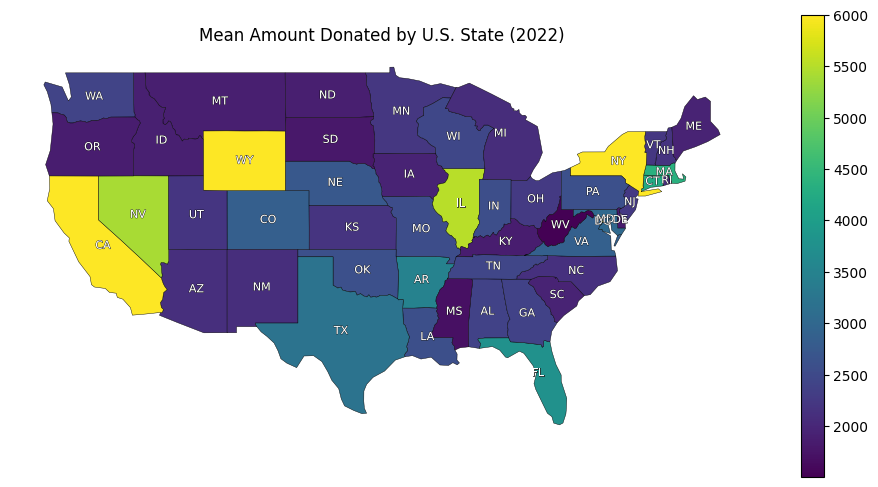

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

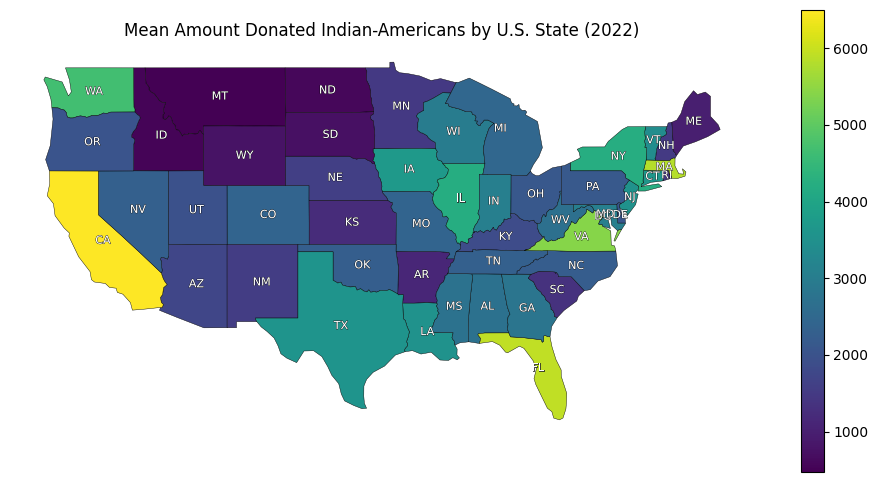

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6500
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

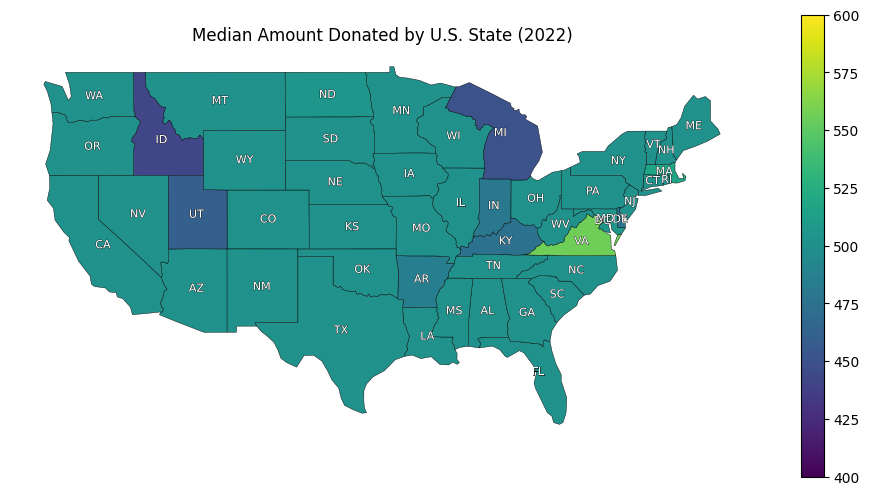

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=400,
    vmax=600
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

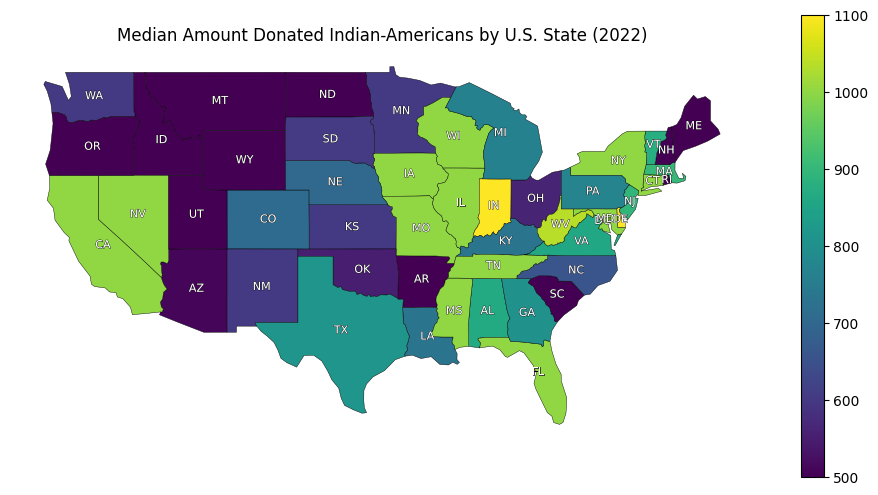

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=500,
    vmax=1100
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

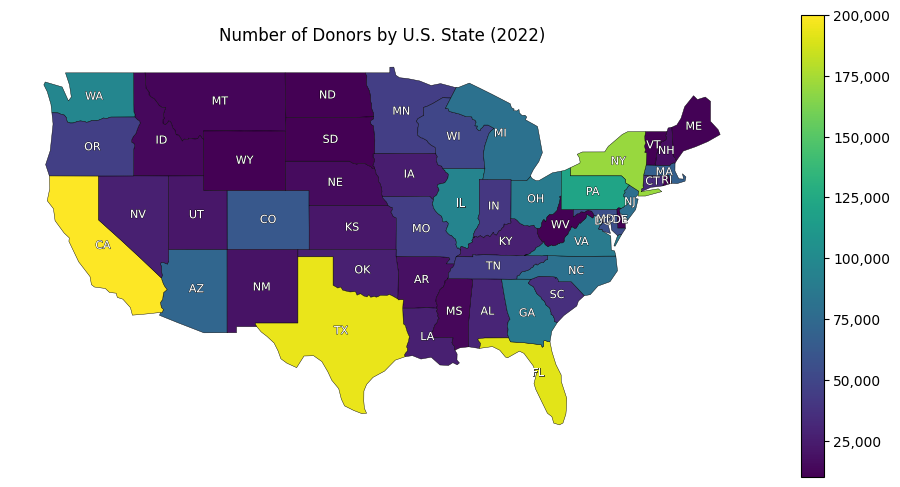

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="donor_count",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=10000,
    vmax=200000
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Donors by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

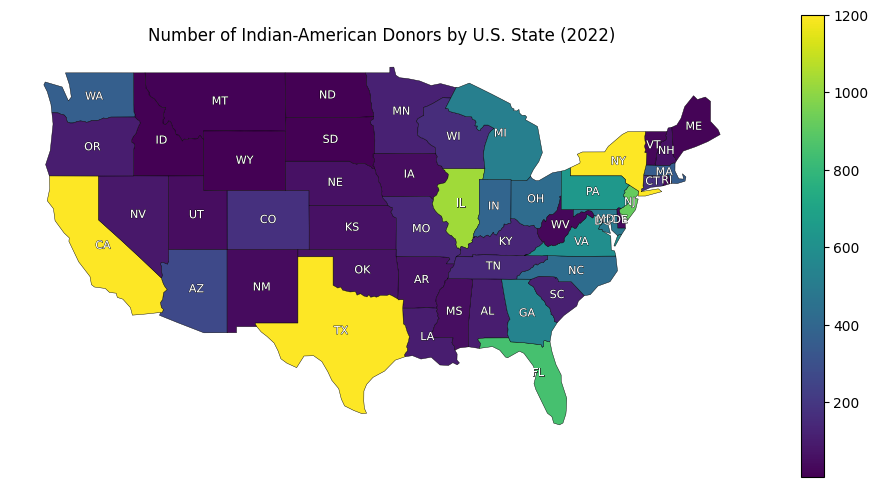

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="donor_count_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1200
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Indian-American Donors by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

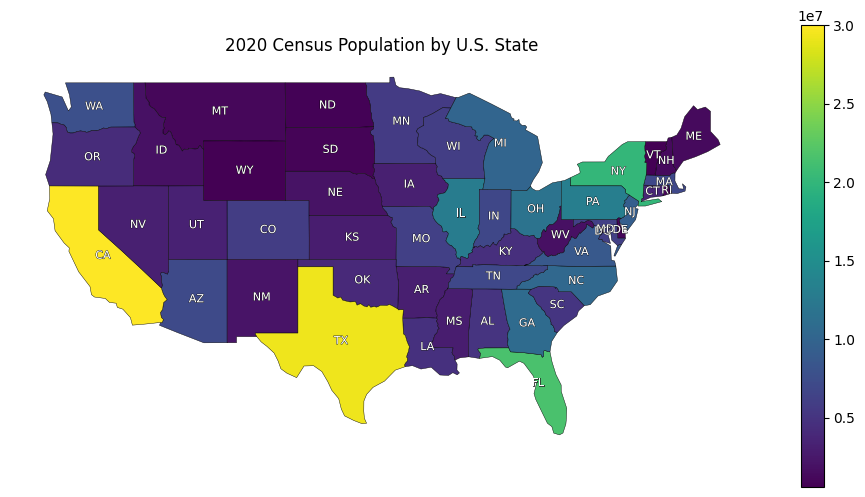

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Census Pop",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=30000000,
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"2020 Census Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

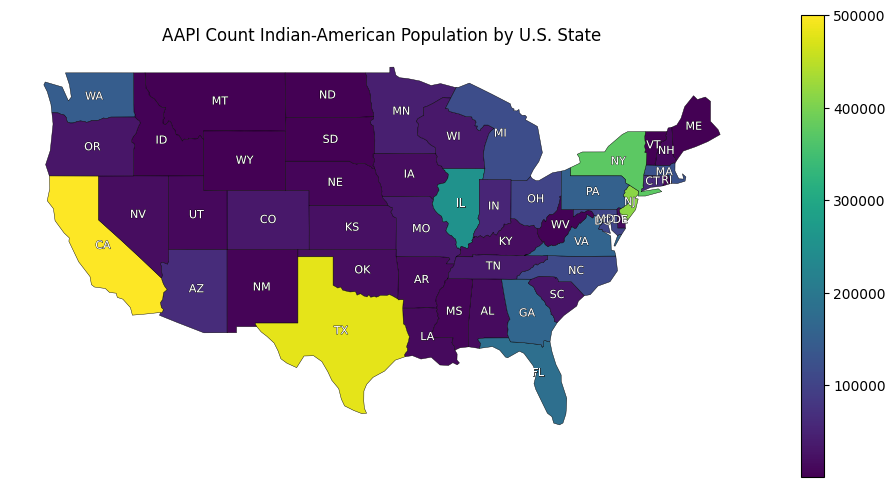

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Indian Pop",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=500000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count Indian-American Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

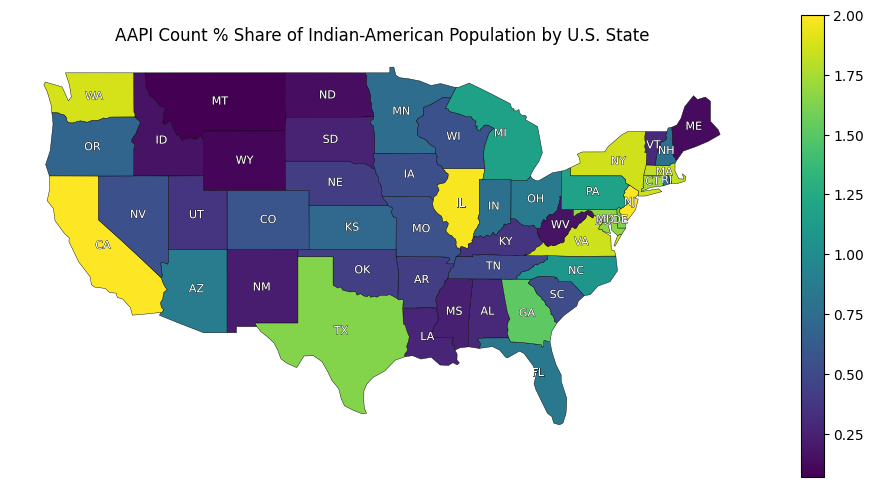

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Share",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=2
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count % Share of Indian-American Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [29]:
gdf_merged["don_per_capita"] = gdf_merged["donor_count"] / gdf_merged["Census Pop"] * 100
gdf_merged["don_per_capita_indian"] = gdf_merged["donor_count_indian"] / gdf_merged["Indian Pop"] * 100
gdf_merged["don_per_capita_diff"] = gdf_merged["don_per_capita_indian"] - gdf_merged["don_per_capita"]
gdf_merged["dollars_per_capita"] = gdf_merged["total_donations"] / gdf_merged["Census Pop"]
gdf_merged["dollars_per_capita_indian"] = gdf_merged["total_donations_indian"] / gdf_merged["Indian Pop"]
gdf_merged["dollars_per_capita_diff"] = gdf_merged["dollars_per_capita_indian"] - gdf_merged["dollars_per_capita"]

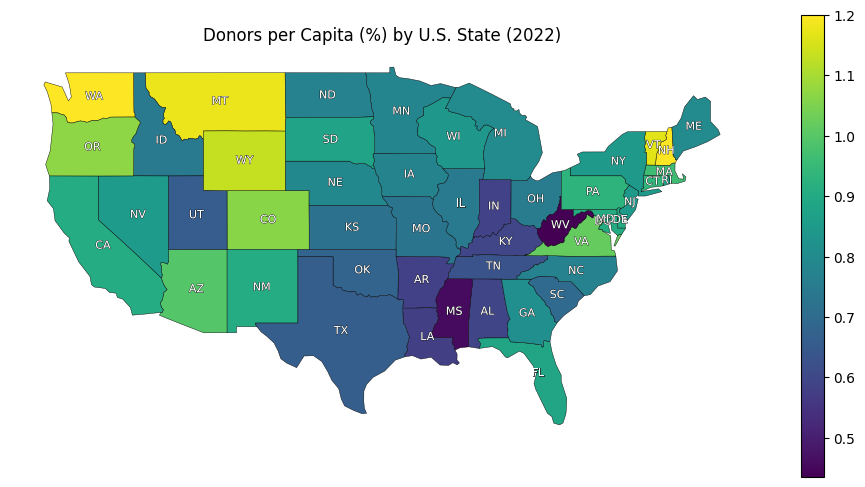

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.2
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Donors per Capita (%) by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

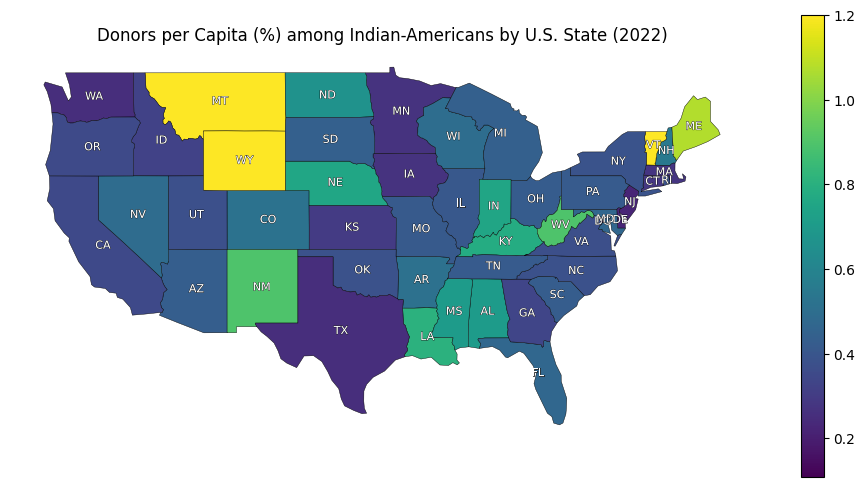

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.2
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Donors per Capita (%) among Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

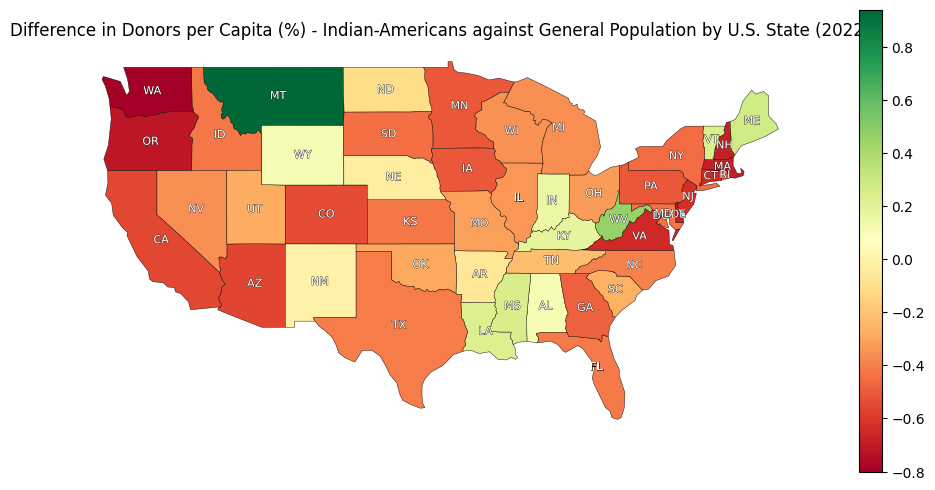

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-0.8
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in Donors per Capita (%) - Indian-Americans against General Population by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

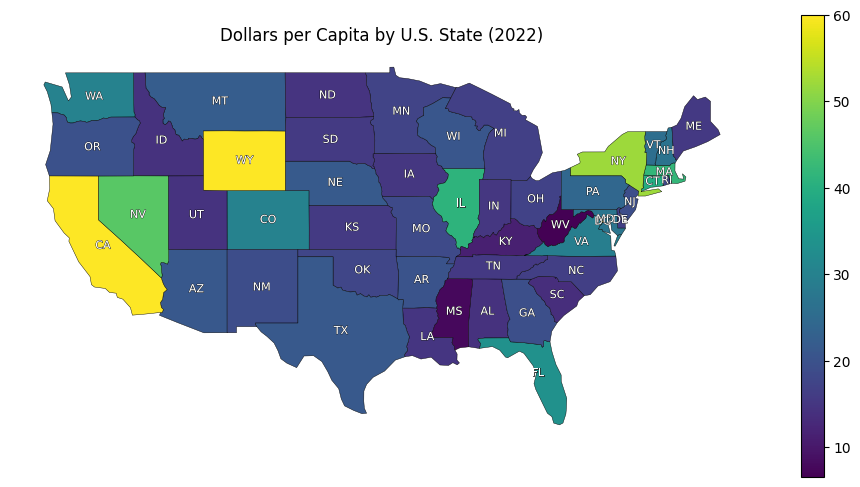

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=60
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars per Capita by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

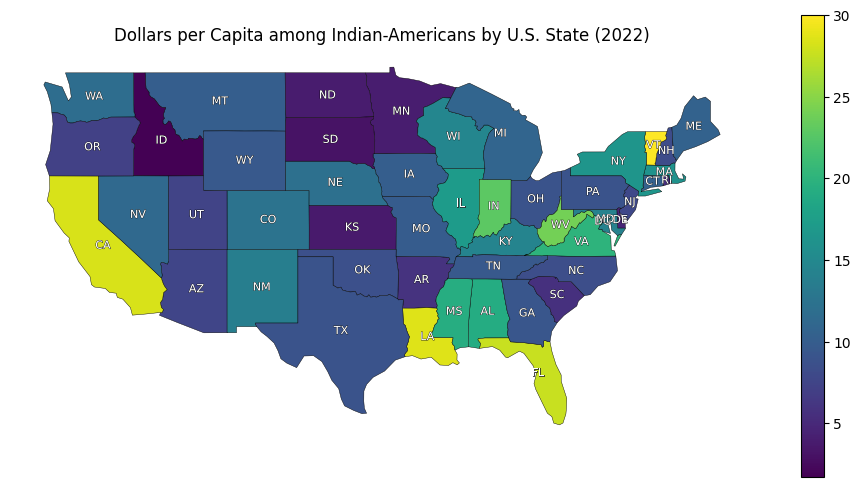

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=30
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars per Capita among Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

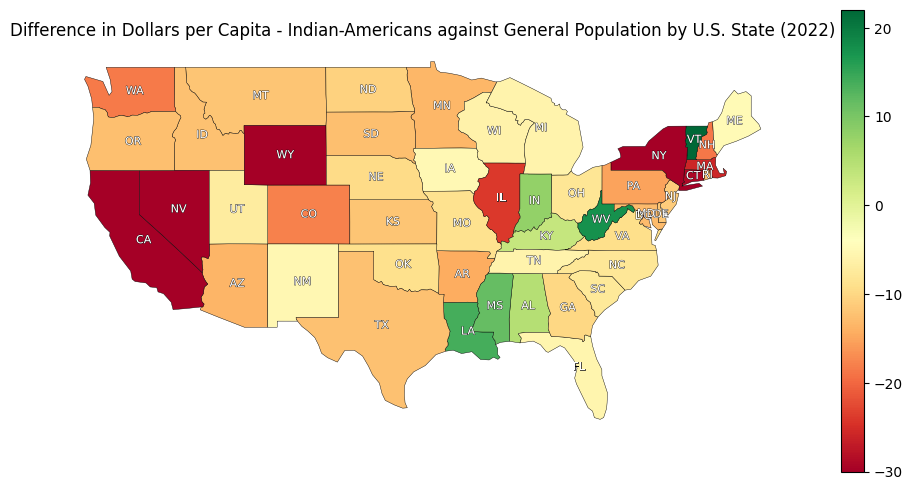

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-30
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in Dollars per Capita - Indian-Americans against General Population by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()